In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm.auto import tqdm


#### Paths of saved UMAP coordinates to calculate batch score

In [ ]:
umap_csv_paths = sorted(list(Path('/path/to/umaps').glob('*umap*/*.csv')))
print(umap_csv_paths)



#### Count nearest neighbors


In [ ]:
def count_nearest_neighbor(df, batch_column='plate', k_nn=200):
    X = df[['umap_x','umap_y']].to_numpy()
    nbrs = NearestNeighbors(n_neighbors=k_nn, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)

    same_plate_nn_count = []
    for idx in tqdm(range(df.shape[0])):
        # convert indices to plate names
        nearest_plates = df.loc[df.index[indices[idx]]][batch_column].to_numpy()
        # first one is always self
        selfplate = nearest_plates[0]
        # others
        nearest_plates = nearest_plates
        # count how many cells from same plate
        same_plate_nn_count.append((selfplate == nearest_plates).sum())
        
    df[f'same_plate_nn_{batch_column}'] = same_plate_nn_count
    
    return df


In [ ]:
k_nn = 200
dfs = []
for csv_path in umap_csv_paths:
    df = pd.read_csv(csv_path, low_memory=False).reset_index(drop=True)
    df['plate_well'] = df['plate'].astype('str') + '_' + df['well'].astype('str')
    df['plate_well_fov'] = df['plate'].astype('str') + '_' + df['well'].astype('str') + '_' + df['fov'].astype('str')
    # Calculate for different batch effects
    df = count_nearest_neighbor(df, batch_column='plate')
    df = count_nearest_neighbor(df, batch_column='plate_well')
    df = count_nearest_neighbor(df, batch_column='plate_well_fov')
    save_name = csv_path.parent / 'nn_count_1_200_platewell.csv'
    # save
    df.to_csv(save_name, index=False)
    # add to list
    dfs.append(df)

#### Batch score calculation

In [ ]:
batch_column = 'plate'
nn_count_column = f'same_plate_nn_{batch_column}'
for df in dfs:
    plate_percentage = {}
    for grpn, grpdf in df.groupby(by=batch_column):
        plate_percentage[grpn] = grpdf.shape[0] / df.shape[0]
    df['plate_perc'] = df[batch_column].map(plate_percentage)
       
    df['same_plate_ratio'] = df[nn_count_column] / k_nn

    df['same_plate_ratio'] = df['same_plate_ratio'] / df['plate_perc']
    df['logp'] = np.log2(df['same_plate_ratio'])

Calculate mean batch score with confidence interval

In [ ]:
import scipy.stats as st 
def get_ci(df, col='same_plate_ratio', alpha=0.95):

    meanv = df[col].mean()
    stdv = df[col].std()

    low, high = st.norm.interval(alpha=alpha,
                     loc=df[col].mean(), 
                     scale=st.sem(df[col].to_numpy())) 
    return low, high, meanv

In [ ]:
stats = {}
for df, csv_path in zip(dfs, umap_csv_paths):
    low, high, meanv = get_ci(df, col='logp', alpha=0.95)
    experiment_key = csv_path.parent.stem # Identifier between experiments
    
    stats[experiment_key] = [low, high, meanv] 

Refactored dictionary {low_ci, high_ci, mean_score}

In [ ]:
stats = {
    'No Correction' : [0.4000630751318601, 0.40246135396175764, 0.4012622145468089] ,
    'LinearR, Plate' : [0.3683377601816099, 0.3705952979022169, 0.3694665290419134] ,
    'LinearR, Plate+Well' : [0.36641501974092516, 0.3686653512623578, 0.36754018550164147] ,
    'LinearR, Plate+Well+FOV' : [0.347603099393163, 0.3498209295966362, 0.3487120144948996] ,
    'LinearR, Well' : [0.38915055758283285, 0.39145335820195387, 0.39030195789239336] ,
    'LinearR, FOV' : [0.38218613291931197, 0.38449921063702613, 0.38334267177816905] ,
    'LinearR, Well+FOV' : [0.375142960910258, 0.3774372131362851, 0.37629008702327155] ,
    'PyComBat, Plate' : [0.20215757033009485, 0.2039106982775159, 0.20303413430380537] ,
    'PyComBat, Plate+Well' : [0.16336055365998667, 0.16489708365335384, 0.16412881865667026] ,
    'Harmony, Plate' : [0.15855122071425826, 0.16008917181439664, 0.15932019626432745] ,
    'Harmony, Plate+Well' : [0.13770356569155595, 0.13912554180581116, 0.13841455374868356] ,
    'No batch effect (shuffled data)' : [0.09625352242313197, 0.09745159170076954, 0.09685255706195076] ,
}

Corrected percentage against 'No Correction'

In [ ]:
for key in stats1:
    print(f"{100*(stats1[key][2] - stats1['No Correction'][2])/stats1['No Correction'][2]:.2f}", key)

0.00 No Correction
-7.92 LinearR, Plate
-8.40 LinearR, Plate+Well
-13.10 LinearR, Plate+Well+FOV
-2.73 LinearR, Well
-4.47 LinearR, FOV
-6.22 LinearR, Well+FOV
-49.40 PyComBat, Plate
-59.10 PyComBat, Plate+Well
-60.30 Harmony, Plate
-65.51 Harmony, Plate+Well
-75.86 No batch effect (shuffled data)


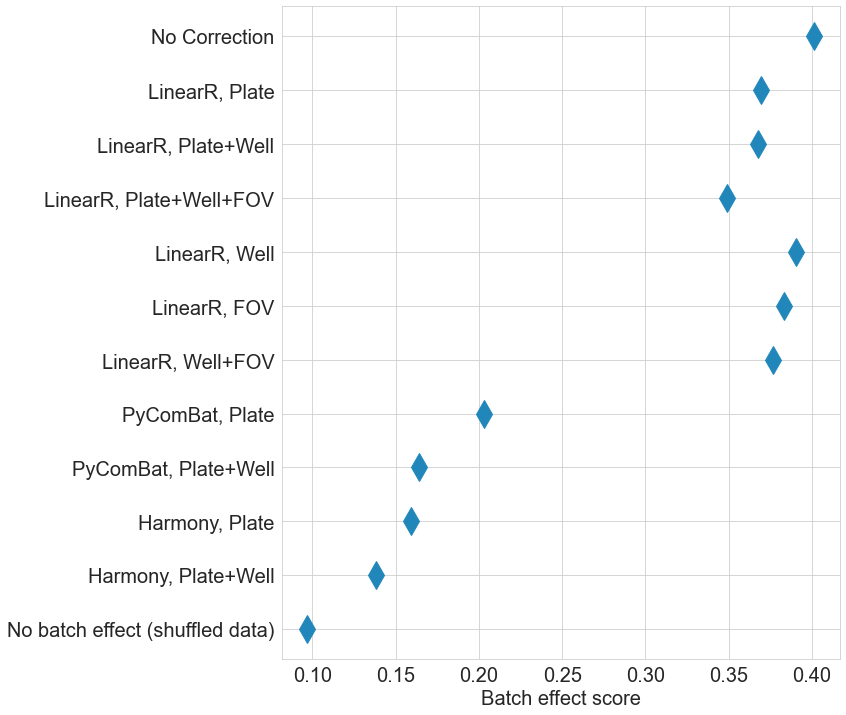

In [ ]:
sns.set_style('whitegrid')

def plot_confidence_intervaly(x, values, color='#f44336', horizontal_line_width=0.5):
    top = values[0]
    bottom = values[1]
    meanv = values[2]

    plt.plot(meanv, x, 'd', color='#2187bb', markersize=20)
    # left = x - horizontal_line_width / 2
    # right = x + horizontal_line_width / 2
    # plt.plot([top, bottom], [x, x], color=color)
    # plt.plot([top, top], [left, right], color=color)
    # plt.plot([bottom, bottom], [left, right], color=color)

xtick_pos = list(range(len(stats)))
xtick_pos.reverse()
xtick_names = list(stats.keys())

plt.figure(figsize=(10,12))
plt.yticks(xtick_pos, xtick_names, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("Batch effect score", fontsize=20)

for xtick, key in zip(xtick_pos, stats):
    plot_confidence_intervaly(xtick, stats[key])

plt.show()